In [63]:

import pandas as pd 
import numpy as np 
from  scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import shapely

import geopandas as gpd
from tqdm import tqdm 

from shapely.ops import cascaded_union

from pomme.utils import filter_liste_electorale,points_to_poly

import pandas as pd 
import numpy as np 
from  scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import shapely

import geopandas as gpd
from tqdm import tqdm 

from shapely.ops import cascaded_union


In [64]:
#Chargement de la BAN
base_insee= pd.read_csv('../db/carto/table-adresses-reu.csv')

/var/folders/rc/0g2xxgc57fq40kc5jwsm7h_c0000gn/T/ipykernel_78590/4100350255.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  base_insee= pd.read_csv('../db/carto/table-adresses-reu.csv')


In [65]:
base_insee.head(10)

,code_commune_ref,reconstitution_code_commune,id_brut_bv_reu,id,geo_adresse,geo_type,geo_score,longitude,latitude,api_line,nb_bv_commune,nb_adresses
0,1001,2,01001_1,01001_0045,Rue des Bles d'Or 01400 L'Abergement-Clémenciat,street,0.85,4.926090,46.151757,BANN,1,5
1,1001,1,01001_1,01001_0040_00101,101 Impasse Bellevue 01400 L'Abergement-Clémen...,housenumber,0.91,4.924261,46.134889,BANG,1,1
2,1001,1,01001_1,01001_0175_00106,106 Route des Garaudes 01400 L'Abergement-Clém...,housenumber,0.91,4.923428,46.133930,BANG,1,1
3,1001,1,01001_1,01001_0230_00190,190 Impasse des Lilas 01400 L'Abergement-Cléme...,housenumber,0.91,4.923083,46.146773,BANG,1,2
4,1001,2,01001_1,01001_0175_00192,192 Route des Garaudes 01400 L'Abergement-Clém...,housenumber,0.95,4.923743,46.133608,BANG,1,3
5,1001,1,01001_1,01001_0115_00194,194 Route de Clémenciat 01400 L'Abergement-Clé...,housenumber,0.91,4.926512,46.133390,BANG,1,1
6,1001,1,01001_1,01001_0265_00194,194 Rue de Munetville 01400 L'Abergement-Cléme...,housenumber,0.91,4.923193,46.150688,BANG,1,1
7,1001,1,01001_1,01001_0175_00194,194 Route des Garaudes 01400 L'Abergement-Clém...,housenumber,0.91,4.923590,46.133477,BANG,1,1
8,1001,1,01001_1,01001_0175_00196,196 Route des Garaudes 01400 L'Abergement-Clém...,housenumber,0.91,4.923156,46.133561,BANG,1,2
9,1001,1,01001_1,01001_0300_00108,108 Impasse du Panoramique 01400 L'Abergement-...,housenumber,0.91,4.921115,46.148606,BANG,1,1


In [66]:

# commune_shapes_path = "http://etalab-datasets.geo.data.gouv.fr/contours-administratifs/2022/geojson/communes-5m.geojson"
# communes_france = gpd.read_file(commune_shapes_path)
# communes_france = communes_france.rename(
#     {'code': 'insee'}, axis=1
# )[['insee', 'geometry']]

# communes_france.to_file('../db/communes_france.geojson', driver='GeoJSON')

communes_france = gpd.read_file('../db/communes_france.geojson')

In [11]:
communes_france

,insee,geometry
0,01001,"POLYGON ((4.95841 46.15327, 4.95812 46.15316, ..."
1,01002,"POLYGON ((5.43020 45.98277, 5.43001 45.98299, ..."
2,01004,"POLYGON ((5.40882 45.94206, 5.40850 45.94210, ..."
3,01005,"POLYGON ((4.94298 45.97962, 4.94257 45.97949, ..."
4,01006,"POLYGON ((5.57083 45.75338, 5.57219 45.75357, ..."
...,...,...
35089,98830,"MULTIPOLYGON (((165.25608 -20.86528, 165.25637..."
35090,98831,"MULTIPOLYGON (((164.69511 -21.04249, 164.69504..."
35091,98832,"MULTIPOLYGON (((167.03572 -22.29068, 167.03563..."
35092,98833,"MULTIPOLYGON (((165.88247 -21.39642, 165.88252..."


In [80]:
code_insee = 94080
df = filter_liste_electorale(code_insee_commmune=int(code_insee), base = base_insee)
## ta base d'entrée oti avoir des points longitude et latitude
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude)) #créé une colonne geometry avec les coordonnees x et y
x = gdf.geometry.x.values
y = gdf.geometry.y.values
coords = np.vstack((x, y)).T  
vor = Voronoi(coords) # les coordonnees sont transformees pour voronoi

In [81]:
boundary = gpd.GeoDataFrame(geometry = gpd.GeoSeries(communes_france[communes_france.insee=='94080'].geometry )) # définit une limite 

In [82]:
lines = [shapely.geometry.LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line] #Crée le slignes entre clusters 
polys = shapely.ops.polygonize(lines) #Crée les polys
voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys))
voronois=gpd.overlay(voronois, boundary, how='intersection') #Définit le périmètre de la commune et la contrainte des voronois


/var/folders/rc/0g2xxgc57fq40kc5jwsm7h_c0000gn/T/ipykernel_78590/1969656778.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  voronois=gpd.overlay(voronois, boundary, how='intersection') #Définit le périmètre de la commune et la contrainte des voronois


In [83]:
voronois

,geometry
0,"POLYGON ((2.41887 48.84844, 2.41890 48.84854, ..."
1,"POLYGON ((2.41911 48.84838, 2.41906 48.84802, ..."
2,"POLYGON ((2.41917 48.84846, 2.41931 48.84863, ..."
3,"POLYGON ((2.41890 48.84854, 2.41894 48.84868, ..."
4,"POLYGON ((2.44244 48.85245, 2.44250 48.85245, ..."
...,...
2833,"POLYGON ((2.44793 48.85047, 2.44792 48.85025, ..."
2834,"POLYGON ((2.44819 48.85024, 2.44817 48.84993, ..."
2835,"POLYGON ((2.44804 48.85027, 2.44808 48.85023, ..."
2836,"POLYGON ((2.44789 48.85002, 2.44787 48.85003, ..."


In [ ]:
##
def points_to_poly(x, voronois):
    """
    Quand tu crées le svoronois, il mélange tous les points. Ainsi, une liste de n points te renvoie à l'issue de l'application de l'algo une liste de n polygones, le ie point n'est aps dans le ie polygone.
    cette fonction permet de réattribuer les bons polygones au x bons points.  
    Args:
        x (shapely.geometry.point.Point): point
        voronois (gpd.GeoDataFrame): dataframe avec une colonne geometry
        
    Returns:
        _type_: shapely.geometry.polygon.Polygon
        """
    for i in range(voronois.shape[0]):
        if x.within(voronois.loc[i,'geometry']) == True:
            return voronois.loc[i,'geometry']

In [85]:
gdf['poly'] = gdf.apply(lambda x: points_to_poly(x.geometry, voronois), axis=1) 

In [86]:
tmp_bv_carto={}
for  bv in gdf.id_brut_bv_reu.unique(): 
    tmp_carto=gdf[gdf.id_brut_bv_reu == bv]
    voronois_polygons = gpd.GeoSeries(cascaded_union(tmp_carto.poly))
    tmp_bv_carto[bv] = voronois_polygons

/var/folders/rc/0g2xxgc57fq40kc5jwsm7h_c0000gn/T/ipykernel_78590/1158107912.py:4: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  voronois_polygons = gpd.GeoSeries(cascaded_union(tmp_carto.poly))
/var/folders/rc/0g2xxgc57fq40kc5jwsm7h_c0000gn/T/ipykernel_78590/1158107912.py:4: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  voronois_polygons = gpd.GeoSeries(cascaded_union(tmp_carto.poly))
/var/folders/rc/0g2xxgc57fq40kc5jwsm7h_c0000gn/T/ipykernel_78590/1158107912.py:4: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  voronois_polygons = gpd.GeoSeries(cascaded_union(tmp_carto.poly))
/var/folders/rc/0g2xxgc57fq40kc5jwsm7h_c0000gn/T/ipykernel_78590/1158107912.py:4: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  voronois_polygons = gpd.GeoSeries(cascaded_union(tmp_c

In [92]:
tmp_bv_carto = pd.DataFrame.from_dict(tmp_bv_carto, orient='index').rename(columns={0:'geometry'}).reset_index().rename(columns={'index':'id_brut_bv_reu'})


<Axes: >

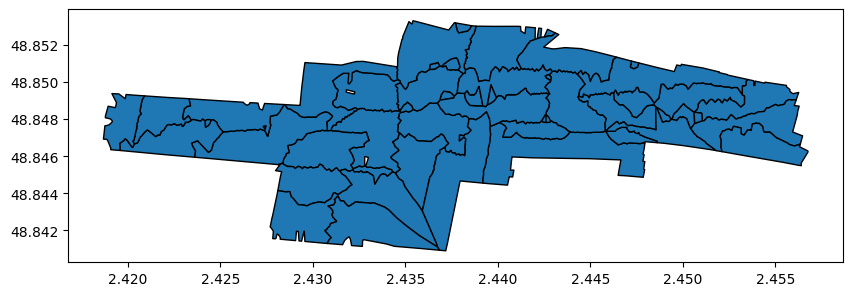

In [93]:
fig,ax = plt.subplots(figsize=(10,10))
voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(tmp_bv_carto.geometry))
voronois.plot(ax=ax, edgecolor='black')

### <center> Fin 

In [196]:
lines = [shapely.geometry.LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]
polys = shapely.ops.polygonize(lines)
voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys))
voronois=gpd.overlay(voronois, boundary, how='intersection')

/var/folders/rc/0g2xxgc57fq40kc5jwsm7h_c0000gn/T/ipykernel_23458/3149101884.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  voronois=gpd.overlay(voronois, boundary, how='intersection')
